# Set Card Game: Relational Neural Network Experiments

## Set Up

In [1]:
import os
import itertools
import numpy as np
import sklearn.model_selection
import sklearn.metrics

import wandb

import tensorflow as tf

from tqdm.auto import tqdm, trange

# %load_ext autoreload
# %autoreload 2
from relational_neural_networks import *
import set_game
from utils import *

### Generate dataset for set card game

In [2]:
X, y = set_game.create_Xy_data(encode=True)
class_names = ['non-set', 'set']

In [3]:
import imblearn.under_sampling
resampler = imblearn.under_sampling.RandomUnderSampler()
res_idx, y_res = resampler.fit_resample(np.array(range(len(y))).reshape(-1,1), y)
X_res = np.array(X)[np.squeeze(res_idx)]

In [4]:
num_extra_attrs = 3 # number of additional spurious attributes to add
num_vals = 3 # num of possible values per additional attribute

def generate_spurious_attr_card_suffix(num_cards, num_attrs, num_vals):

    attr_vals = np.random.randint(0, num_vals,  size=num_cards)
    additional_card_attrs = np.zeros(shape=(num_cards, num_vals))
    additional_card_attrs[np.arange(num_cards), attr_vals] = 1

    for attr in range(1, num_attrs):
        attr_i_vals = np.random.randint(0, num_vals, size=num_cards)
        attr_i_enc = np.zeros(shape=(num_cards, num_vals))
        attr_i_enc[np.arange(num_cards), attr_i_vals] = 1
        additional_card_attrs = np.concatenate([additional_card_attrs, attr_i_enc], axis=1)

    return additional_card_attrs

def generate_spurious_attr_triplet_suffix(num_triplets, num_extra_attrs, num_vals):
    return np.stack([generate_spurious_attr_card_suffix(num_triplets, num_extra_attrs, num_vals) for _ in range(3)], axis=1)

# generate 'data suffix' (additional spurious attributes for each triplet of cards)
data_suffix = generate_spurious_attr_triplet_suffix(len(X_res), num_extra_attrs, num_vals)

# append spurious attribute to X
X_res_w_spurious = np.concatenate([X_res, data_suffix], axis=-1)

In [5]:
data_suffix.shape, X_res_w_spurious.shape

((12960, 3, 9), (12960, 3, 21))

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_res_w_spurious, y_res, test_size=0.4, val_size=0.1)

In [7]:
y_val = tf.one_hot(y_val, 2)
y_test = tf.one_hot(y_test, 2)

batch_size = 256
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

2022-11-10 00:46:31.496741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 00:46:31.588402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 00:46:31.589249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 00:46:31.597574: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
print(f'# of training samples:   {len(y_train): 5}')
print(f'# of validation samples: {len(y_val): 5}')
print(f'# of testing samples:    {len(y_test): 5}')

# of training samples:    6479
# of validation samples:  1297
# of testing samples:     5184


## Models

In [9]:
# set up W&B logging
%load_ext dotenv
%dotenv

%env "WANDB_NOTEBOOK_NAME" "set-learning-curves.ipynb"
%env "WANDB_SILENT" "true"

import wandb
wandb.login(key='283ce55537fabf61a55a960f2788ffcbf12a5b46')

import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

cannot find .env file
env: "WANDB_NOTEBOOK_NAME"="set-learning-curves.ipynb"
env: "WANDB_SILENT"="true"


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
# define common components across models

def create_callbacks():
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, mode='auto', restore_best_weights=True),
        # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
#         wandb.keras.WandbCallback(
#             monitor="val_loss", log_weights=False, log_gradients=False, save_model=False, save_graph=False,
#             # training_data=train_ds, validation_data=val_ds,
#             # labels=['non-set', 'set'], predictions=64,
#             compute_flops=True)
        ]
    return callbacks

metrics = [
#         tf.keras.metrics.BinaryAccuracy(name='acc'),
#         tf.keras.metrics.Precision(class_id=1, name='precision'),
#         tf.keras.metrics.Recall(class_id=1, name='recall'),
#         tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
        ]

loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

fit_kwargs = {'epochs': 100}

# def eval_metrics(model):

#     print('test set')
#     pred_proba_test = model.predict(test_ds)
#     pred_test = np.argmax(pred_proba_test, axis=1)
#     print(sklearn.metrics.classification_report(y_test[:,1], pred_test))

#     return pred_proba_test, pred_test

def log_to_wandb(y_test, pred_proba_test, pred_test):
    # log test-set metrics to W&B
    y_test = np.array(y_test[:,1])
    wandb.log({"pr": wandb.plot.pr_curve(y_test, pred_proba_test, class_names)})
    wandb.log({"roc": wandb.plot.roc_curve(y_test, pred_proba_test, labels=class_names)})
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(y_true=y_test, preds=pred_test, class_names=class_names)})
    
    acc = sklearn.metrics.accuracy_score(y_test, pred_test)
    prec = sklearn.metrics.precision_score(y_test, pred_test)
    recall = sklearn.metrics.recall_score(y_test, pred_test)
    f1 = sklearn.metrics.f1_score(y_test, pred_test)
    rocauc = sklearn.metrics.roc_auc_score(y_test, pred_proba_test[:,1])
    
    wandb.log({
        'test accuracy': acc, 'test precision': prec,
        'test recall': recall, 'test f1': f1,
        'test roc-auc': rocauc})

    
plt.style.use('seaborn-whitegrid')
def plot_learning_curve(train_sizes, accuracies):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(train_sizes, accuracies)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Test Accuracy')
    return fig

In [11]:
n_entities, base_encoding_dim = X_train.shape[1:]

In [12]:
max_train_size = 500
train_size_step = 50
train_sizes = np.arange(train_size_step, max_train_size+1, step=train_size_step)

num_trials = 10 # num of trials per train set size

In [13]:
project_name = 'SET-learning-curves-3'

### Non-relational model: MLP

In [14]:
def create_model():
    input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

    x = tf.keras.layers.Flatten(name='flatten')(input_)

    x = tf.keras.layers.Dense(32, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    non_rel_mlp = tf.keras.Model(input_, x, name='non_rel_mlp')
    non_rel_mlp.compile(loss=loss, optimizer=opt, metrics=metrics)

    return non_rel_mlp

In [15]:
accuracies = []

for train_size in tqdm(train_sizes, desc='train size'):

    train_size_accs = []
    for trial in trange(num_trials, desc='trial', leave=False):
        run = wandb.init(project=project_name, group='Non-relational MLP', name=f'train size = {train_size}; trial = {trial}',
                         config={'train size': train_size, 'trial': trial})
        model = create_model()

        X_train_ = X_train[:train_size]
        y_train_ = y_train[:train_size]
        y_train_ = tf.one_hot(y_train_, 2)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)

        history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), verbose=0, **fit_kwargs)

        pred_proba_test = model.predict(test_ds)
        pred_test = np.argmax(pred_proba_test, axis=1)
        log_to_wandb(y_test, pred_proba_test, pred_test)

        acc = np.mean(pred_test==y_test[:, 1])
        train_size_accs.append(acc)

    accuracies.append(np.mean(train_size_accs))

    wandb.finish(quiet=True)

train size:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


2022-11-10 00:46:42.859866: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-10 00:46:44.984995: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:47:41.217916: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:47:41.308512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:47:41.661966: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:47:42.187933: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:49:13.578008: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:49:14.280067: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:49:14.334687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:49:14.399176: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:49:14.459895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:49:58.930475: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:49:58.985578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:49:59.076331: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:49:59.339155: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:49:59.366747: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:50:52.171084: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:51:38.024825: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:51:38.116343: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:51:38.770815: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:52:37.655574: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:52:37.872478: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:52:38.361854: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:52:38.443168: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:53:24.130986: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:54:12.036011: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:54:12.065108: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:54:12.322501: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 00:55:01.050043: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:55:01.386037: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:55:49.626491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:56:40.154282: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:56:40.337137: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:56:40.731118: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:56:40.876700: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:56:41.058828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:56:41.154588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:56:41.208305: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:56:41.322544: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 00:57:28.347252: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:58:14.004105: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:58:14.367539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:59:00.821981: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:59:00.851702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:59:00.946795: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:59:01.258094: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:59:01.915347: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:59:02.155749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 00:59:46.832952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 00:59:47.599966: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:00:34.681564: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:00:35.025706: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:00:35.055357: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:00:35.251220: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:00:35.311289: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:00:35.437307: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:00:35.611229: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:00:35.702288: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 01:01:21.197828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:01:21.446084: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:01:21.601050: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:01:22.056025: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:01:22.280732: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:02:14.015278: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:02:14.201817: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:02:14.359311: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:02:14.417194: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:02:14.705287: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:02:14.793410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:02:14.879820: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 01:03:00.714804: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:03:46.968838: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:03:47.563007: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:03:47.633877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:03:47.667975: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:03:47.779678: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:03:47.890564: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:03:48.265783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:04:32.041563: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:04:32.261601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:04:32.289924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:04:32.315972: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:04:32.495648: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:04:32.558037: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:04:32.707467: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:04:32.859573: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 01:05:31.289236: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:05:31.409498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:05:31.504238: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:05:31.653954: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:06:17.851286: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:06:17.913923: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:06:18.216670: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:06:18.496669: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:06:18.526505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:06:18.625027: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:06:19.383500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:07:06.597109: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:07:06.920789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:07:55.568134: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:07:55.597182: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:07:56.176760: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:07:56.205457: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:07:56.473005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:08:43.300730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:09:27.435479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:09:27.611439: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:09:27.837848: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:09:28.774311: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:10:28.027910: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:10:28.415243: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 01:11:12.387552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:11:13.251479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:11:13.402449: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:11:13.624817: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:12:00.853680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:12:01.198513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:12:01.512592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:12:46.891926: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:12:46.919636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:13:43.022481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:13:43.049636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:13:43.623736: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:13:43.650665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:13:43.714071: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:13:43.769645: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:13:43.894191: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:13:43.985868: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 01:15:15.499436: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:15:16.113673: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:15:16.150574: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:15:16.463787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:16:01.146610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:16:01.286854: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:16:01.426024: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:16:01.636244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:16:02.306226: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:16:47.976321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:16:48.633667: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:16:48.663318: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:16:48.958285: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:16:48.987303: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:17:33.509006: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:17:33.556345: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:17:33.920758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:17:34.168697: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:17:34.637414: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:18:21.871864: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:18:21.901108: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:18:21.931274: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 01:19:12.249490: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:19:12.850741: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:19:12.966173: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:19:13.021039: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:19:13.172567: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:19:13.501643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:20:02.526694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:20:02.876646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:20:02.938501: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:20:03.412922: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:21:36.468259: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:21:36.496321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:21:36.550720: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:21:36.578334: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:21:36.605547: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:22:22.586873: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:22:22.679586: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:22:22.923798: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:22:22.985299: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:22:23.047826: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:22:23.235034: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:23:10.017063: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:10.104894: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:10.134499: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:10.162233: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:10.207230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:10.501697: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:10.755597: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:10.785838: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 01:23:55.462871: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:55.618211: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:55.985719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:56.233260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:23:56.358018: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:24:44.565789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:24:44.801780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:24:44.998167: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:24:45.044300: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:25:29.834802: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:25:29.865150: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:25:29.896458: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:25:30.390975: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:25:30.847057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:26:18.825853: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:26:19.351659: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:26:19.499298: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 01:27:04.546019: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:27:05.178799: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:27:05.239254: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:27:05.334005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:27:05.363137: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:27:52.517817: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:27:53.182729: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:28:39.733931: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:28:39.765279: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:28:40.308569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:30:15.655462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:30:15.921245: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:30:16.019992: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:30:16.460455: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:31:03.583562: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:31:04.109604: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:31:52.747095: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:31:52.795503: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:31:52.851958: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:31:53.136483: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:31:53.199922: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:32:42.848856: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:32:42.949060: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:32:43.333560: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:32:43.832328: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:33:28.689733: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:34:16.312427: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 01:35:01.539588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:35:48.608231: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:35:48.800327: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:35:50.000076: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:35:50.163260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:35:50.238466: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:36:35.551904: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:36:35.648580: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:36:35.742434: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:36:36.041592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:36:36.515034: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:36:36.576992: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:37:23.842633: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:37:24.672920: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:38:10.256121: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:38:10.918897: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:38:57.542388: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:39:41.924741: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:40:28.995666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:41:15.359640: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:41:15.645701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:41:15.921961: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:42:03.061897: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:42:03.540746: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:42:03.634558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:42:03.667623: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:42:03.749119: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 01:42:49.220015: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:42:49.344651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:42:49.404083: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:43:36.708384: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2022-11-10 01:44:24.063240: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:44:24.377995: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:44:24.473039: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:44:24.758930: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:44:24.795992: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:45:11.082511: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:11.390477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:11.829092: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:11.859336: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:11.922384: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:45:55.740835: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:55.907141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:56.383739: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:56.490243: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:56.761000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:56.954384: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:45:57.091125: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:46:44.343206: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:46:44.533570: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:48:17.537994: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:48:17.658794: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:48:18.101638: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:48:18.162769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:49:03.130328: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:49:03.203991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:49:03.236994: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:49:03.267044: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:49:03.433469: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:49:49.874205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 01:51:23.556529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:51:23.927617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:51:23.989328: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:51:24.180538: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:51:24.731707: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:52:08.451647: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:52:08.814587: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:52:08.883335: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:52:09.452902: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:52:56.762437: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:52:57.329456: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:52:57.392573: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:52:57.422184: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:53:41.311938: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:53:41.501631: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:53:41.764807: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:53:41.833910: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:53:42.508750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:54:28.481907: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:54:28.576927: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:54:28.641287: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:54:29.093651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:54:29.433688: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:54:29.463015: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:55:14.095510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:55:14.200287: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:55:14.270842: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:55:14.731373: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:56:02.068640: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:56:02.227642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:56:02.256989: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:56:02.481294: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:56:47.713919: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:56:48.454368: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:57:36.009649: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:57:36.099671: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:57:36.288509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:57:37.052504: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 01:58:20.906195: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 01:59:16.670270: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 01:59:17.269689: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:00:04.405146: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:00:04.495803: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:00:51.399856: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:00:51.520868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:01:36.901492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:01:37.607622: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:01:37.735871: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:01:38.020640: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:02:23.848336: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:02:23.909348: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:02:24.282454: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:02:24.327973: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:02:24.435565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:02:24.596763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:02:24.683587: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:02:24.852703: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:03:09.433249: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:04:09.912809: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:04:10.423342: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:04:54.676278: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:04:54.773060: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:04:54.961453: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:04:55.117453: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:04:55.439096: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:05:40.787374: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:05:40.817788: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:05:41.119902: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:05:41.192571: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:05:41.550868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:05:41.611467: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


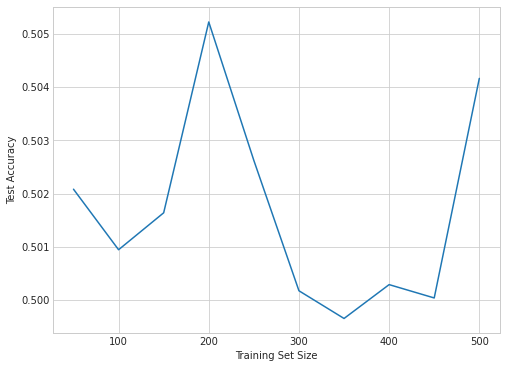

In [16]:
plot_learning_curve(train_sizes, accuracies);

### CoRelNet

In [17]:
def create_corelnet_model(n_entities, base_encoding_dim, encoder_constructor, name='CoRelNet'):
    input_ = tf.keras.layers.Input(shape=(n_entities, base_encoding_dim), name='input_entity_seq')

    if encoder_constructor is not None:
        x = EntityEncoder(encoder_constructor, name='encode_entities')(input_)
    else:
        x = input_

    x = RelInnerProduct(name='relation_inner_prod')(x)

    x = tf.keras.layers.Flatten(name='flatten')(x)

    x = tf.keras.layers.Dense(9, activation='relu', name='dense1')(x)

    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    corelnet = tf.keras.Model(input_, x, name=name)

    corelnet.compile(loss=loss, optimizer=opt, metrics=metrics)

    return corelnet

#### CoRelNet: No Encoder

In [18]:
def create_model():
    return create_corelnet_model(n_entities, base_encoding_dim, encoder_constructor=None)

In [19]:
accuracies = []

for train_size in tqdm(train_sizes, desc='train size'):

    train_size_accs = []
    for trial in trange(num_trials, desc='trial', leave=False):
        run = wandb.init(project=project_name, group='CoRelNet (no encoder)', name=f'train size = {train_size}; trial = {trial}',
                         config={'train size': train_size, 'trial': trial})
        model = create_model()

        X_train_ = X_train[:train_size]
        y_train_ = y_train[:train_size]
        y_train_ = tf.one_hot(y_train_, 2)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)

        history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), verbose=0, **fit_kwargs)

        pred_proba_test = model.predict(test_ds)
        pred_test = np.argmax(pred_proba_test, axis=1)
        log_to_wandb(y_test, pred_proba_test, pred_test)

        acc = np.mean(pred_test==y_test[:, 1])
        train_size_accs.append(acc)

    accuracies.append(np.mean(train_size_accs))

    wandb.finish(quiet=True)

train size:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 02:06:27.387857: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:06:27.569607: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:06:28.323648: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2022-11-10 02:07:14.814971: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:07:14.845728: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:07:14.881769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:07:15.057552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:07:15.355362: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:07:15.412777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

2022-11-10 02:08:00.445494: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:08:00.766754: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:08:00.827698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:08:49.271190: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:08:50.153356: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:08:50.389136: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2022-11-10 02:09:35.925047: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:09:35.990860: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:09:36.253337: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:09:36.861358: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:10:23.824304: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:10:24.517333: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:10:24.709535: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:11:10.318128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:11:10.398607: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:11:56.458751: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:11:56.499697: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:11:56.717293: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:11:56.943085: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:11:57.678105: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:12:41.938571: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:12:41.968202: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:12:41.994696: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:12:42.526962: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:12:42.840063: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:12:43.378352: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:13:30.107215: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:13:30.499606: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:13:30.745932: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 02:14:16.872906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:14:16.966869: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:14:17.672166: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:15:03.998818: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:15:04.955690: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:15:49.507217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:15:49.640278: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:15:50.424755: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:16:36.810922: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:16:37.034714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:16:37.123166: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:17:22.308565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:18:10.227924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:18:10.257766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:18:10.286452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:18:56.171468: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:18:56.232812: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:18:56.358186: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:18:56.607504: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:19:43.103445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:19:43.163661: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:19:43.876198: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:20:28.155258: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:20:28.328089: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:20:28.408153: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:20:28.467897: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:20:28.864246: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:20:29.295933: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:21:17.402256: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:21:18.490365: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:21:18.547082: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:21:18.737075: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:21:19.252316: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:21:19.297576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 02:22:02.555454: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:02.642310: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:02.706788: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:02.857052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:02.921274: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:02.983630: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:03.142696: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:03.225694: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:22:49.502617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:51.334963: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:51.395956: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:22:51.489286: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2022-11-10 02:23:35.283010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:23:35.691144: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:23:36.347493: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:24:22.019265: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:24:22.049320: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:24:22.209498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:24:23.084000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:24:23.804665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:24:24.035974: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:25:09.159816: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:09.401850: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:09.463143: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:09.638221: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:11.250767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:11.341806: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:11.403434: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:25:56.220980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:56.310040: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:56.613705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:57.252997: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:25:58.774033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:26:41.521608: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:26:41.864484: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:26:42.478885: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:26:42.536331: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:26:42.744275: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:26:43.006325: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:26:43.189039: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:26:44.663195: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:27:29.134128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:27:29.643435: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:28:13.591111: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:28:13.972777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:28:14.847771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:28:14.908544: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:28:15.028561: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:28:15.355558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:29:00.793922: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:29:00.947063: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 02:29:46.089858: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:29:46.249502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:29:47.263026: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:30:32.348351: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:30:32.378788: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:30:32.407305: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:30:32.436234: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:30:32.464925: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:30:32.496694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:30:32.956214: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:30:33.964230: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:31:21.467352: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:31:21.568258: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:31:21.661976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:31:21.793328: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:31:22.368555: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:31:22.772566: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:32:08.397415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:08.488878: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:08.697801: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:08.755390: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:08.784186: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:08.871196: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:08.929491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:09.019683: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:32:52.465181: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:52.538085: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:53.060672: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:53.115058: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:53.296153: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:53.383313: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:53.454575: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:32:53.482360: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:33:38.859903: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:33:38.892320: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:33:38.923864: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:33:38.981583: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:33:39.008759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:33:39.036295: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:33:39.660060: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:33:39.722744: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:34:25.465540: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:34:27.149511: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:34:27.389010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:35:15.064371: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:35:15.911148: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:35:15.966248: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:35:16.057192: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:35:16.851035: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:35:16.913099: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:35:17.024376: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:35:17.088846: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:36:00.556212: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:36:00.982038: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:36:01.695130: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:36:01.844406: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:36:01.873886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:36:47.577327: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:36:48.000600: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:36:48.043205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:36:48.106748: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:36:48.231358: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 02:37:33.626694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:38:20.135011: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:38:20.198169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:38:20.369928: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:38:20.753218: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:38:20.985164: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:38:21.014202: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:38:21.105269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:38:21.133445: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:39:06.209536: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:39:06.876619: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:39:07.005389: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:39:09.032205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:39:54.154551: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:39:54.283337: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:39:55.365018: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:40:38.811768: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:40:38.896903: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:40:39.025432: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:40:39.585573: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:40:39.647473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:40:40.794734: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:40:40.912886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:40:41.069555: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:41:34.245675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:41:34.488772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:42:19.299238: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:42:19.369335: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:42:19.886322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:42:20.132500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:42:20.330561: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:42:20.422865: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:42:21.578218: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:42:21.849433: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:43:06.512289: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:06.827032: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:07.087885: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:07.845355: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:08.427105: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:08.605584: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:08.752053: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:43:51.874705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:52.363068: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:52.602792: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:52.696447: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:53.255542: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:43:53.283972: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:44:39.355940: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:44:40.488256: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:44:40.518065: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:44:40.549177: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:44:41.466868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:44:41.498719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:44:41.813742: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 02:45:25.210844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:45:26.292732: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:45:26.625101: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:45:26.844405: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:45:27.219066: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:46:11.895531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:46:13.075701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:46:13.251257: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:46:13.382617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:46:13.799662: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2022-11-10 02:46:58.267553: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:46:58.678374: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:46:58.771694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:47:45.481637: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:47:45.542189: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:47:45.606853: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:47:46.260012: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:47:47.159852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:48:30.270224: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:48:30.995029: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:48:31.219822: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:48:31.769164: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:48:31.900854: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:49:20.123160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:49:20.536190: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:50:04.773589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:50:04.905599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:50:51.314918: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:50:52.153608: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:50:52.217837: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:50:52.566719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:50:53.251222: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:50:53.590133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:50:53.683542: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:50:53.931113: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:51:37.168576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:52:25.280731: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:52:25.439122: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:52:25.847420: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:52:25.914605: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:52:26.198618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:52:26.332397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:52:26.924836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:52:26.985262: W tensorflow/core/data/root_dataset.cc:16

trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 02:53:09.991809: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:53:10.751830: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:53:11.540931: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:53:59.593591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:00.767368: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:01.241646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:01.274702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:01.306236: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:01.338809: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:01.370820: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:02.142974: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:54:45.425022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:45.611795: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:46.682685: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:54:46.948231: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 02:55:32.443447: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:55:33.389766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2022-11-10 02:56:19.108669: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:56:19.173575: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:56:19.298034: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:56:19.951626: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:56:19.981743: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2022-11-10 02:57:06.668827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:07.521216: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:08.157153: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:08.352615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:08.906291: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:09.009849: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:09.215644: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:10.139243: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:57:52.360272: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:52.520148: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:52.890231: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:52.920681: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:53.144967: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:53.687478: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:54.097338: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:57:54.732177: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 02:59:25.647150: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:59:26.440216: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:59:26.578076: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:59:27.063039: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:59:27.740200: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 02:59:27.834941: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:00:21.946307: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:00:22.144854: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:00:22.238463: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 03:01:06.348712: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:06.768712: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:06.929325: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:06.995782: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:07.054197: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:07.649685: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:09.990257: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:01:54.174779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:54.332860: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:54.365079: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:55.276695: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:55.991684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:01:56.594861: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

2022-11-10 03:02:40.179717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:02:40.879490: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:02:40.979292: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:02:43.003369: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:02:43.220650: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:02:43.273874: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:02:43.415558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:02:43.451759: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 03:03:32.591225: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:03:32.778827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:03:33.069976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:03:33.227321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:03:33.292572: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:03:33.324719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:03:33.866141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:03:33.898978: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 03:04:19.916792: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:04:20.910554: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:04:21.042674: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:04:22.264990: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:05:07.625046: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:08.159722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:08.630169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:08.766843: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:08.956683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:05:53.152669: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:53.282925: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:53.697185: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:53.759507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:53.853822: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:53.919242: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:53.950409: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:05:54.074400: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 03:06:41.968588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:06:42.029360: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:06:42.556654: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:07:28.580771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:07:28.969924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:07:29.215090: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:07:29.583821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:07:29.669570: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:08:15.891969: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:08:17.113999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 03:09:02.794134: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:02.826643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:03.474363: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:03.546219: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:04.188160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:04.285599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:06.000683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:06.354033: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 03:09:51.096876: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:51.320190: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:51.461847: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:52.031891: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:52.290802: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:52.540940: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:09:52.934429: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classificatio

2022-11-10 03:10:36.766090: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:10:37.147174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:11:28.465274: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:12:12.656582: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:12:13.279873: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:12:13.374339: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:13:00.440488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:13:00.721784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2022-11-10 03:13:45.133999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:13:45.333997: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:13:45.494124: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:13:45.617167: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:13:45.825942: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:13:46.173367: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:13:46.204974: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:13:46.298547: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 03:14:33.495410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:14:34.310715: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:15:25.359823: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:15:25.626201: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:15:26.095783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:16:12.638980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:16:13.468005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


trial:   0%|          | 0/10 [00:00<?, ?it/s]

2022-11-10 03:16:59.024309: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:17:45.691977: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:17:45.739029: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:17:46.034375: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:17:48.436084: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:17:49.213160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:17:49.553576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:17:49.589042: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:17:50.005335: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 03:18:32.393844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:18:32.539943: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:18:32.613644: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:18:33.078859: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:18:33.204512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:18:33.237677: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:18:33.494694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:19:19.732304: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:19:20.661102: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:19:20.860846: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:19:21.437876: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:19:22.112589: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:19:22.145870: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:19:22.448098: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:19:22.786047: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 03:20:06.828794: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:20:07.468768: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:20:09.072557: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:20:54.162603: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:20:55.314811: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:21:39.546594: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:21:40.185065: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:21:40.409809: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:21:42.330366: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:21:42.747095: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:21:42.931116: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:21:43.053391: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:21:43.494729: W tensorflow/core/data/root_dataset.cc:16

2022-11-10 03:22:28.360220: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:22:31.004135: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:22:31.094420: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:22:31.631560: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:23:20.688651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:23:22.450678: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:23:23.589087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:23:23.774707: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


2022-11-10 03:24:07.175449: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:24:07.677673: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:24:08.192564: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:24:08.766290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:24:10.454604: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:24:10.719193: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:24:10.874117: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-11-10 03:24:11.593352: W tensorflow/core/data/root_dataset.cc:16

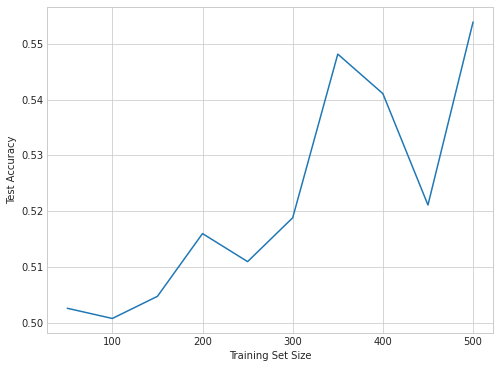

In [20]:
plot_learning_curve(train_sizes, accuracies);

## Relational Neural Network (Fixed Good Encoders)

In [21]:
## RelNN with LinearProjectionEncoder
def create_model():
    input_ = tf.keras.layers.Input(shape=(n_entities,base_encoding_dim), name='input_entity_seq')

    encoder_constructors = [lambda: tf.keras.layers.Dense(3, activation=None, use_bias=False)]*4
    rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')
    # rel_layer.trainable = False

    x = rel_layer(input_)

    x = FlattenTriangular(name='flatten', include_diag=False)(x)

    x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    relnn = tf.keras.models.Model(input_, x, name='relnn')

    relnn.compile(loss=loss, optimizer=opt, metrics=metrics)

    # linear maps extract 1-hot 3-d vecs for each of 4 attrs
    A1 = np.array([[1, 0, 0]+[0]*(base_encoding_dim-3), 
                   [0, 1, 0] + [0]*(base_encoding_dim-3), 
                   [0, 0, 1] + [0]*(base_encoding_dim-3)]).astype(float)
    A2 = np.roll(A1, shift=3)
    A3 = np.roll(A1, shift=6)
    A4 = np.roll(A1, shift=9)

    # fix entity encoders
    for entity_encoder, A in zip(rel_layer.entity_encoders, (A1, A2, A3, A4)):
        entity_encoder.encoder.set_weights([A.T])
        entity_encoder.trainable = False

    return relnn

In [22]:
accuracies = []

for train_size in tqdm(train_sizes, desc='train size'):

    train_size_accs = []
    for trial in trange(num_trials, desc='trial', leave=False):
        run = wandb.init(project=project_name, group='RelNN (fixed good linear encoders)', name=f'train size = {train_size}; trial = {trial}',
                         config={'train size': train_size, 'trial': trial})
        model = create_model()

        X_train_ = X_train[:train_size]
        y_train_ = y_train[:train_size]
        y_train_ = tf.one_hot(y_train_, 2)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)

        history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), verbose=0, **fit_kwargs)

        pred_proba_test = model.predict(test_ds)
        pred_test = np.argmax(pred_proba_test, axis=1)
        log_to_wandb(y_test, pred_proba_test, pred_test)

        acc = np.mean(pred_test==y_test[:, 1])
        train_size_accs.append(acc)

    accuracies.append(np.mean(train_size_accs))

    wandb.finish(quiet=True)

train size:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

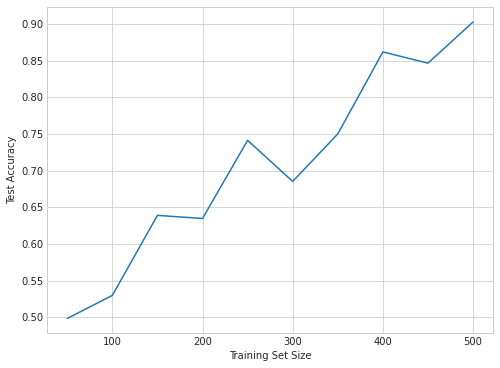

In [23]:
plot_learning_curve(train_sizes, accuracies);

## Relational Neural Network (End-to-end Good Encoders)

In [24]:
## RelNN with LinearProjectionEncoder
def create_model():
    input_ = tf.keras.layers.Input(shape=(n_entities,base_encoding_dim), name='input_entity_seq')

    encoder_constructors = [lambda: tf.keras.layers.Dense(3, activation=None, use_bias=False)]*4
    rel_layer = RelationalLayer(encoder_constructors, name='rel_layer')

    x = rel_layer(input_)

    x = FlattenTriangular(name='flatten_tri', include_diag=False)(x)

    x = tf.keras.layers.Dense(16, activation='relu', name='dense')(x)

    x = tf.keras.layers.Dense(2, activation='softmax', name='output')(x)

    relnn = tf.keras.models.Model(input_, x, name='relnn')

    relnn.compile(loss=loss, optimizer=opt, metrics=metrics)

    return relnn

In [25]:
accuracies = []

for train_size in tqdm(train_sizes, desc='train size'):

    train_size_accs = []
    for trial in trange(num_trials, desc='trial', leave=False):
        run = wandb.init(project=project_name, group='RelNN (learned linear encoders)', name=f'train size = {train_size}; trial = {trial}',
                         config={'train size': train_size, 'trial': trial})
        model = create_model()

        X_train_ = X_train[:train_size]
        y_train_ = y_train[:train_size]
        y_train_ = tf.one_hot(y_train_, 2)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train_, y_train_)).batch(batch_size)

        history = model.fit(train_ds, validation_data=val_ds, callbacks=create_callbacks(), verbose=0, **fit_kwargs)

        pred_proba_test = model.predict(test_ds)
        pred_test = np.argmax(pred_proba_test, axis=1)
        log_to_wandb(y_test, pred_proba_test, pred_test)

        acc = np.mean(pred_test==y_test[:, 1])
        train_size_accs.append(acc)

    accuracies.append(np.mean(train_size_accs))

    wandb.finish(quiet=True)

train size:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

trial:   0%|          | 0/10 [00:00<?, ?it/s]

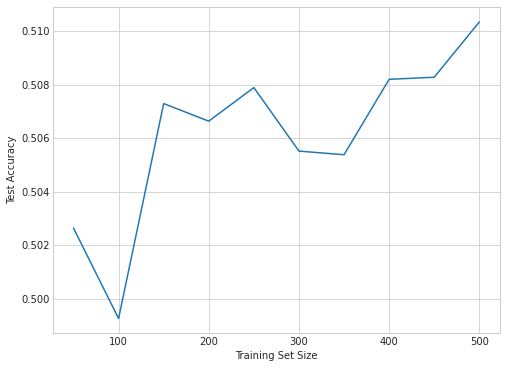

In [26]:
plot_learning_curve(train_sizes, accuracies);